# mitransient tutorial: Rendering in frequency space using `phasor_hdr_film`

## Overview

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>Do a transient render of the Cornell Box scene using the `phasor_hdr_film`</li>
  <li>Visualize the output</li>
</ul>

</div>

### What is rendering in frequency space?

In time-domain rendering you measure the temporal response of a light pulse. This gives a signal s(t) over time. Rendering in frequency space means directly computing specific frequency components of that signal, that is, for some frequencies $\Omega$ you measure
$$
S(\Omega) = \mathcal{F}\left\{s(t)\right\}
$$
where $\mathcal{F}$ represents the Fourier transform. In short, the `phasor_hdr_film` is very similar to `transient_hdr_film` but computes the Fourier transform of the measured values on the go. Later you will see how to choose the frequencies $\Omega$ that you measure (similar to `bin_width_opl`, `start_opl`, etc. configure what values of time you measure).

### Importing `mitransient`
Before importing `mitransient`, you need to import Mitsuba 3 and set a variant (here we use `llvm_ad_rgb`). Only if you want to use more variants, you will need to compile Mitsuba 3 (not `mitransient`) yourself. And you will need to add the compilation folder to the `PYTHONPATH` (see the commented code for how to do that)

<div class="admonition important alert alert-block alert-warning">

For many cases, `mitransient` requires the use of a `llvm_*` or `cuda_*` variant, so we don't recommend using `scalar_rgb`. It will work with any `llvm_*` or `cuda_*` variant, and for most use cases `llvm_ad_rgb` or `cuda_ad_rgb` is enough.

</div>

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_mono')

import mitransient as mitr
print(mitr.__version__)

1.1.2


We use the short alias `mitr` for `mitransient` for improved code readibility.

### Setup the Cornell Box scene

See other tutorials for more information on how to load scenes using XML files. In this case, we have modified the scene's XML file with

```xml
<film type="phasor_hdr_film">
    <integer name="width"  value="$res"/>
    <integer name="height" value="$res"/>
    <float name="wl_mean" value="100"/>
    <float name="wl_sigma" value="100"/>
    <integer name="temporal_bins" value="4000"/>
    <float name="bin_width_opl" value="1"/>
    <float name="start_opl" value="0"/>
    <rfilter type="box">
        <!-- <float name="stddev" value="1.0"/> -->
    </rfilter>
</film>
```

The key values here are `wl_mean` and `wl_sigma`. These values are inspired by the Morlet wavelet filter used in phasor-field-based non-line-of-sight imaging. In practice, `wl_mean` controls the central frequency that is measured and `wl_sigma` is inversely proportional to the bandwidth. The values of $\Omega$ are aligned with the frequency values typical of the discrete Fourier transform corresponding to the `bin_width_opl` and `temporal_bins`.

In [2]:
# Load XML file
# You can also use mi.load_dict and pass a Python dict object
# but it is probably much easier for your work to use XML files
import os
scene = mi.load_file(os.path.abspath('cornell-box/cbox_diffuse_freq.xml'))

### Render the scene in steady and transient domain

<div class="admonition important alert alert-block alert-warning">
Mitsuba 3 and `mitransient` work with Dr.JIT, which has lazy evaluation.
That means the actual image/video will not be computed until you use it.
As such, this cell should take &lt;1s to execute
</div>

In [3]:
data_steady, data_transient = mi.render(scene, spp=128)

In [4]:
print(data_steady.shape, data_transient.shape)

(400, 400, 1) (400, 400, 82)


The result is:
1) A steady state image `data_steady` with dimensions (width, height, channels)
2) A transient image `data_transient` with dimensions (width, height, **frequencies**, channels)

`data_steady` still represents the steady-state render as with previous examples.
`data_transient` contains the measured responses for these frequencyes

### Visualize the steady and transient image
We provide different functions so you can visualize your data in a Jupyter notebook

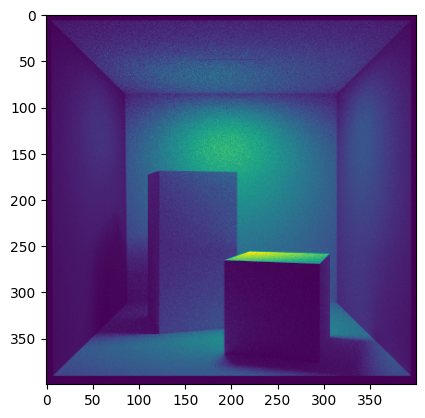

In [5]:
import matplotlib.pyplot as plt

plt.imshow(data_steady)

In [6]:
# Plot the computed steady image
mi.util.convert_to_bitmap(data_steady)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [400, 400],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 469 KiB of image data ]
]

<div class="admonition important alert alert-block alert-warning">
As the frequency measurements are complex-valued, we plot the real part. The first images here correspond to lower frequency components, and they become higher-frequency as you scroll down. Thus you can see how the red and blue lines in the plotted image become higher-frequency.
</div>

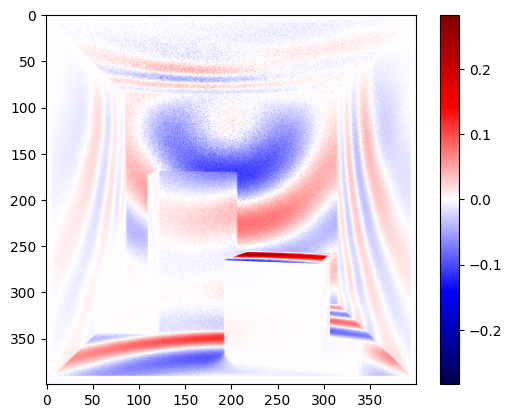

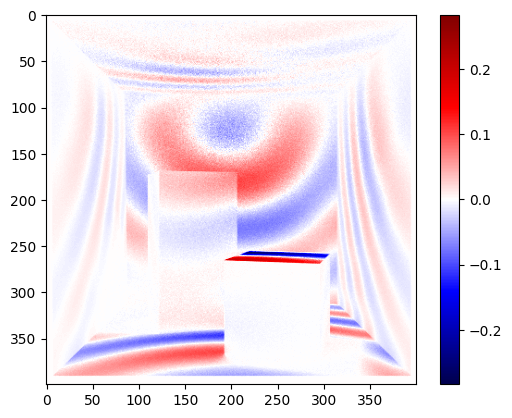

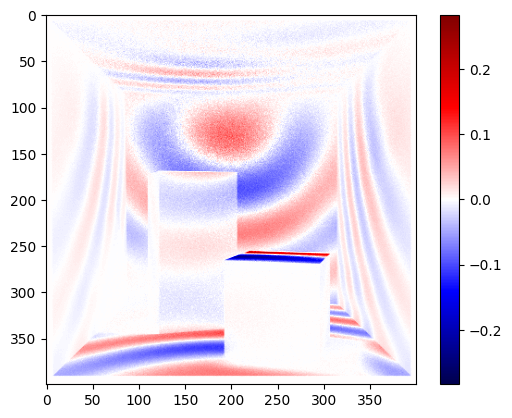

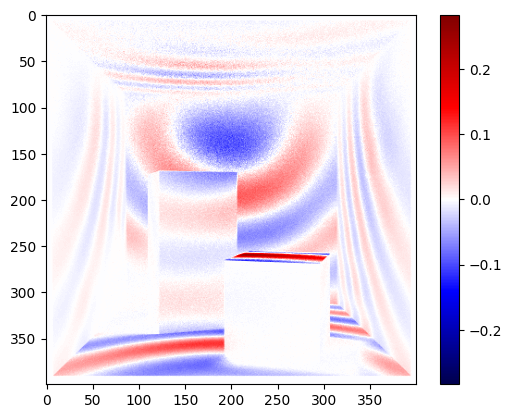

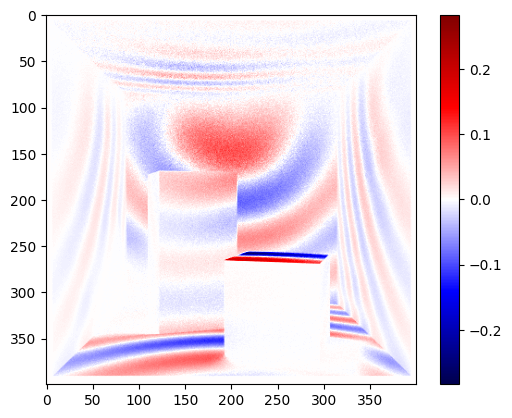

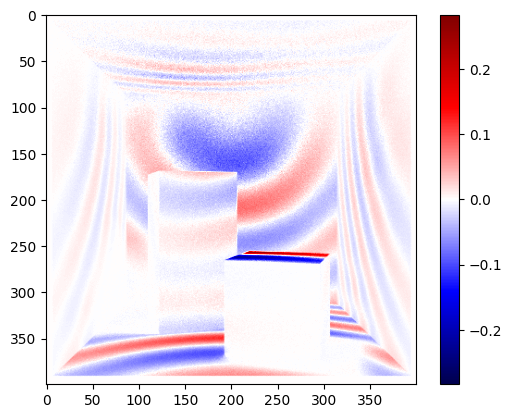

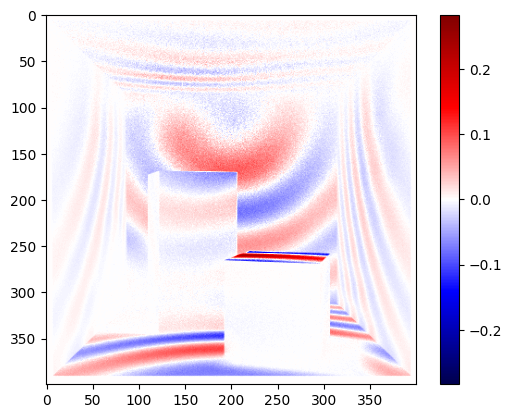

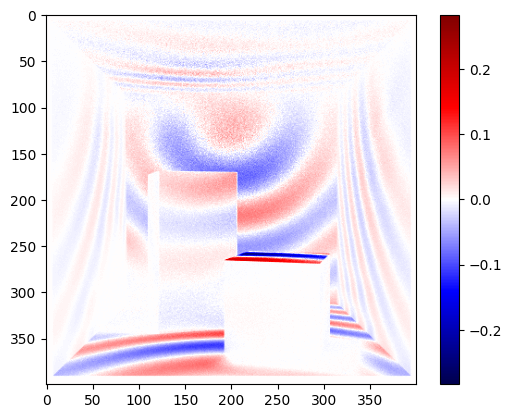

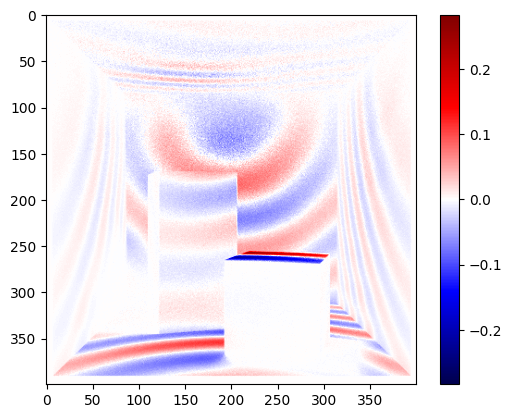

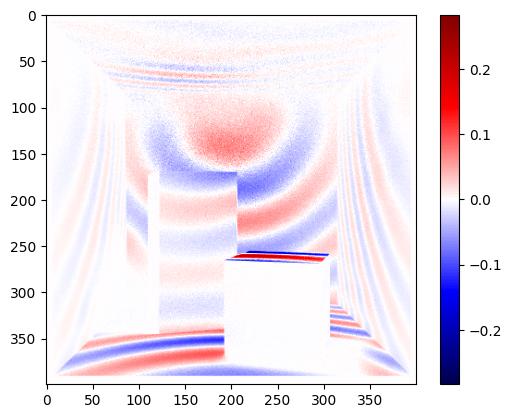

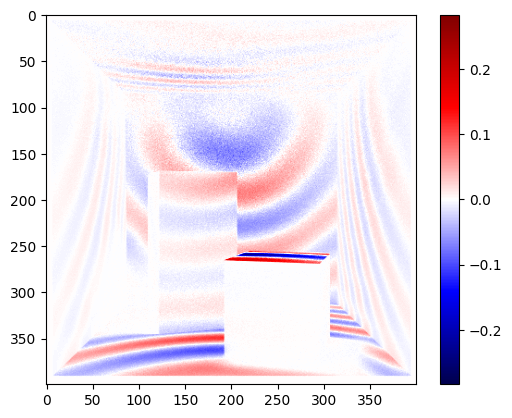

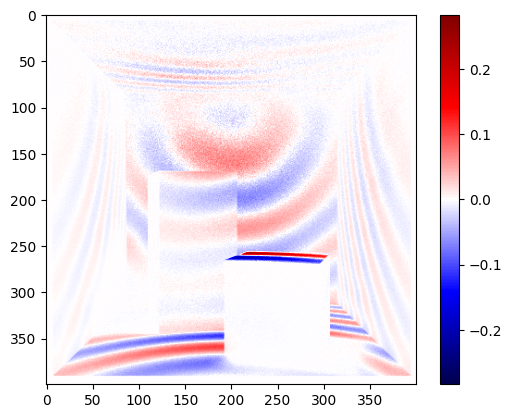

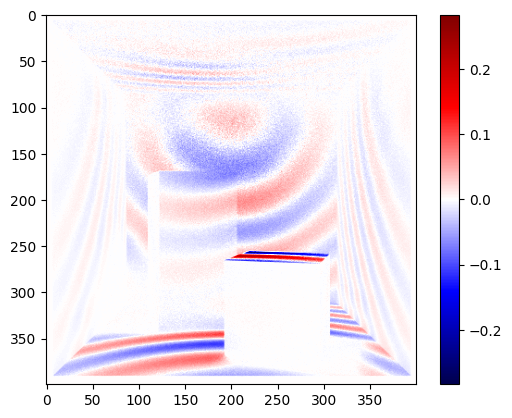

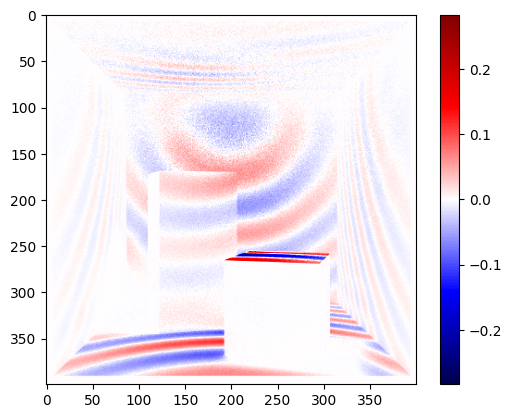

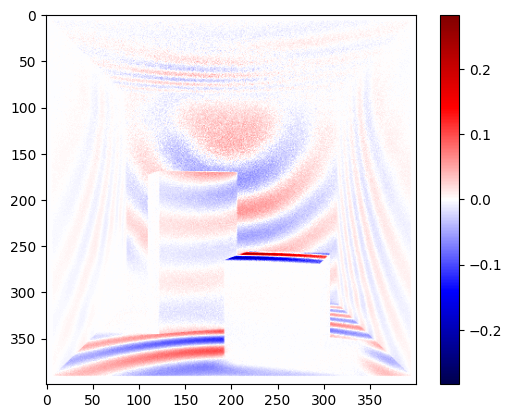

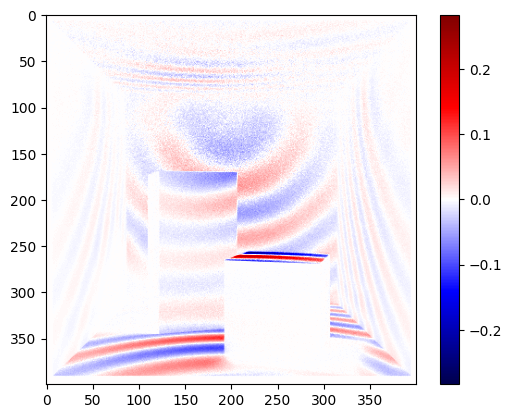

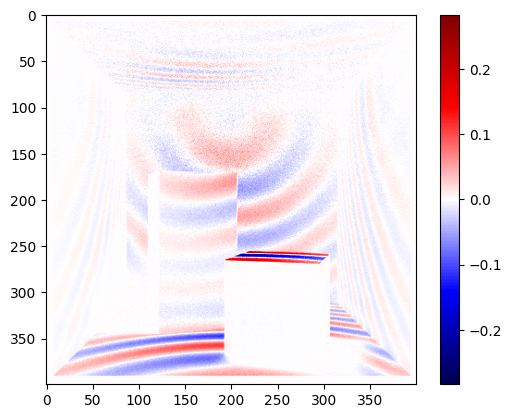

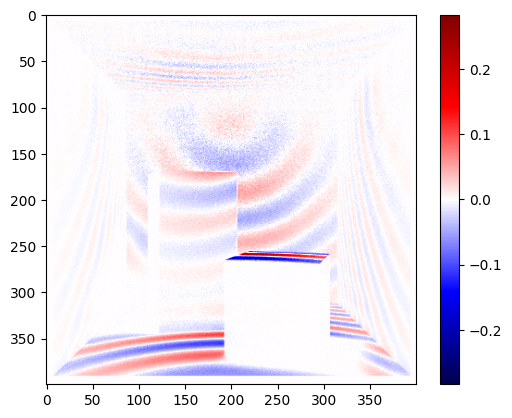

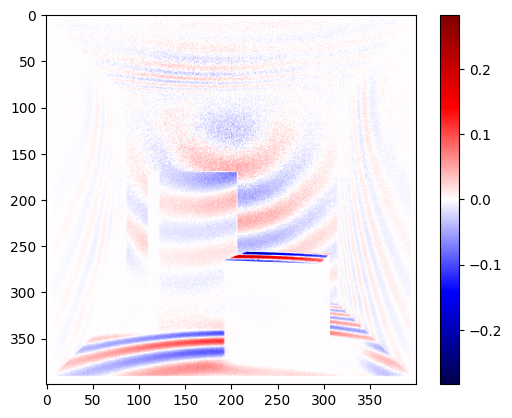

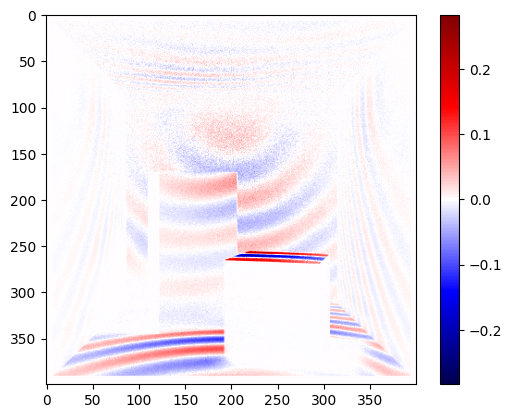

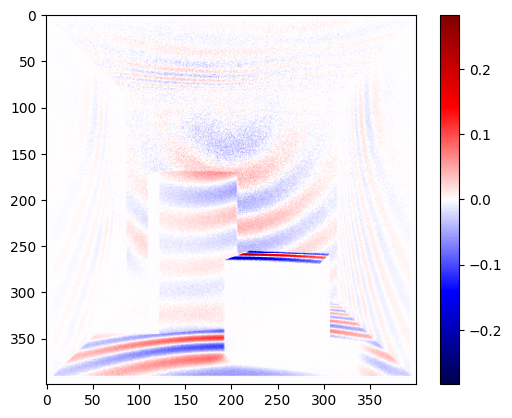

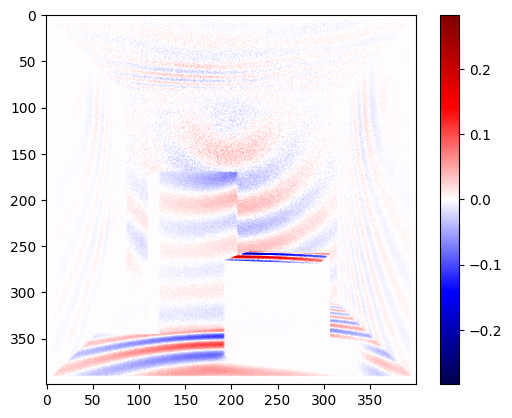

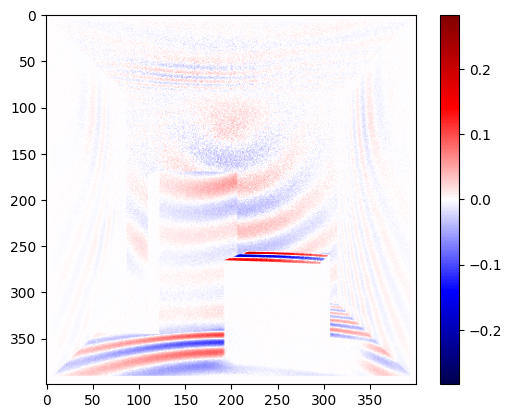

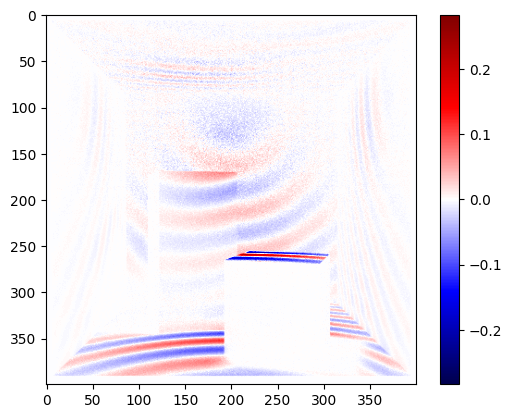

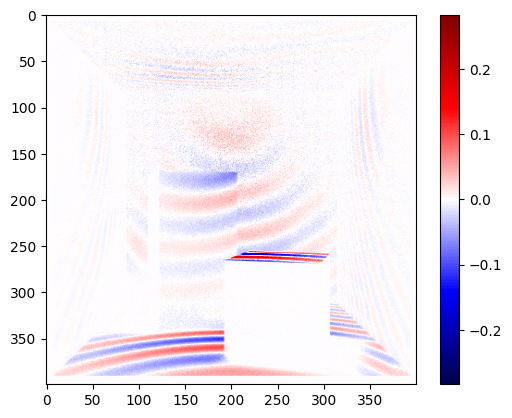

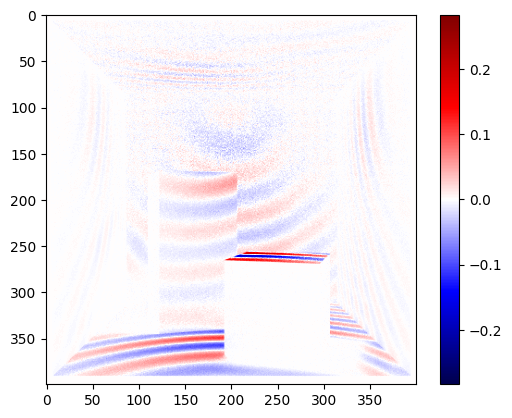

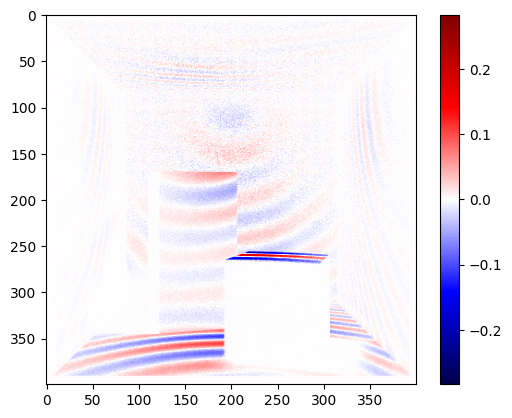

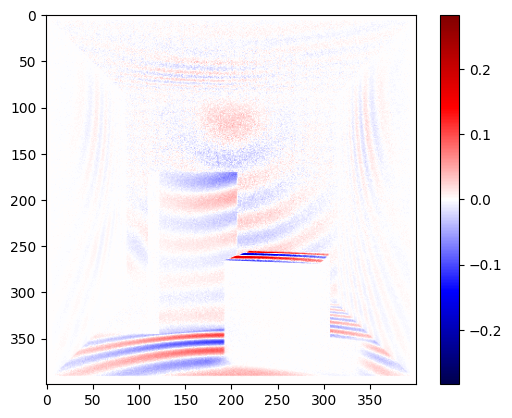

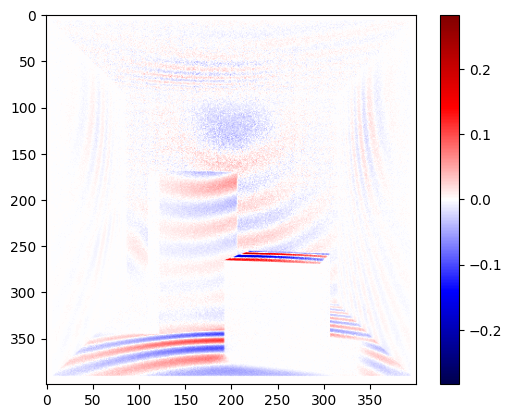

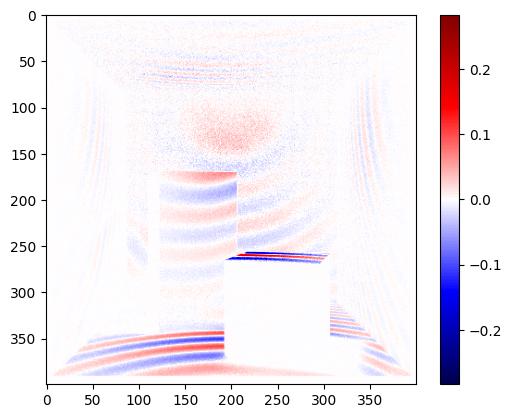

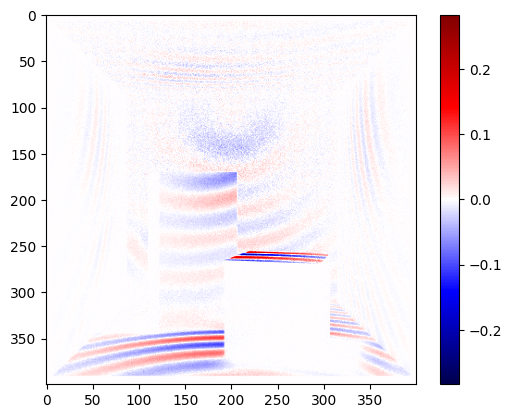

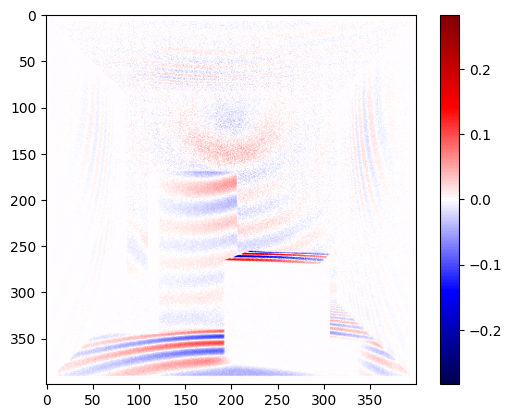

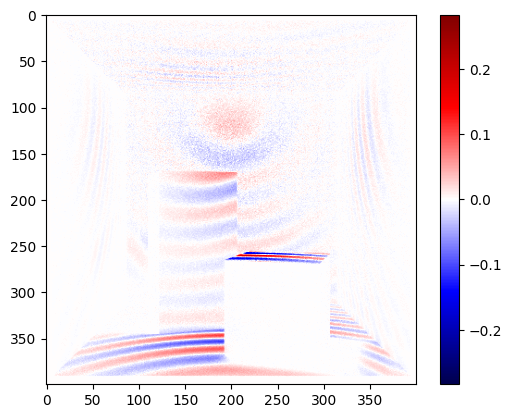

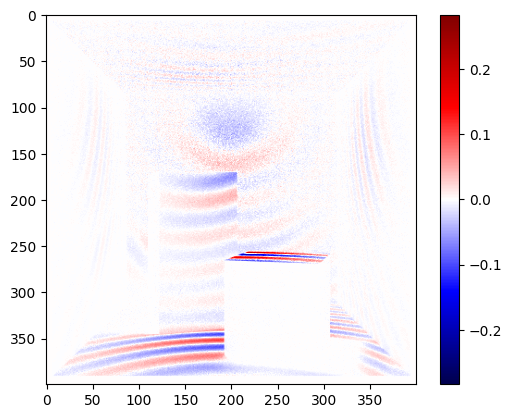

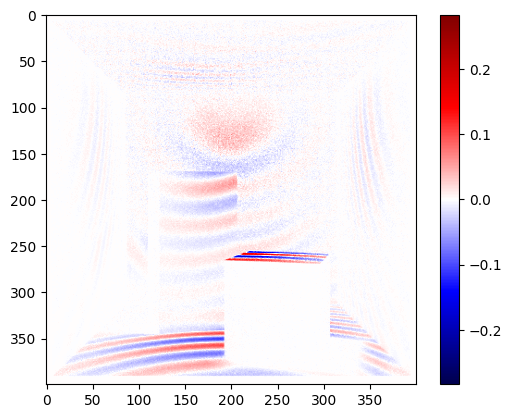

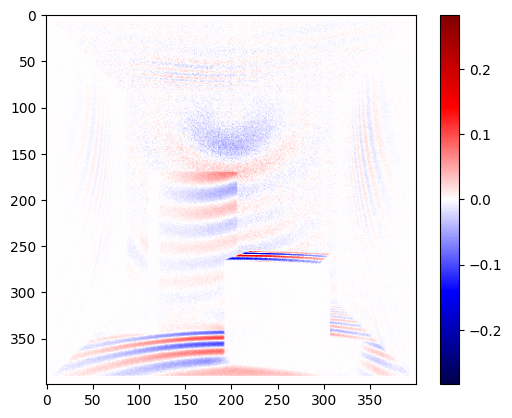

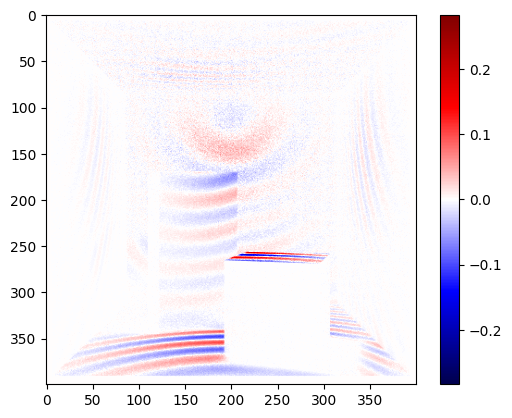

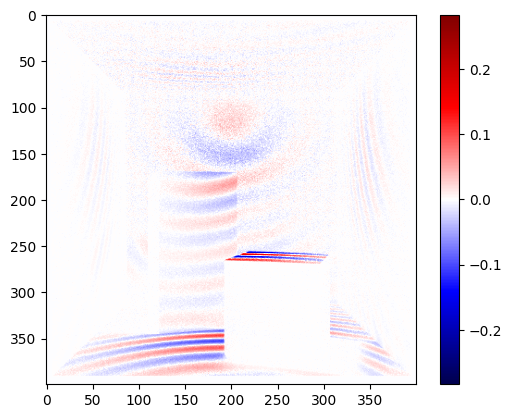

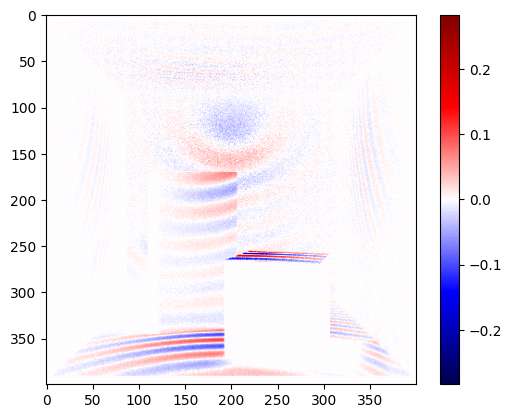

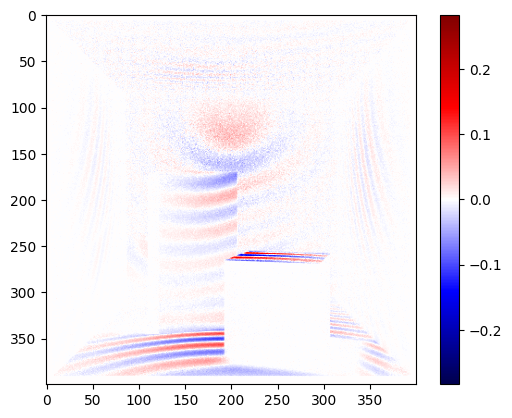

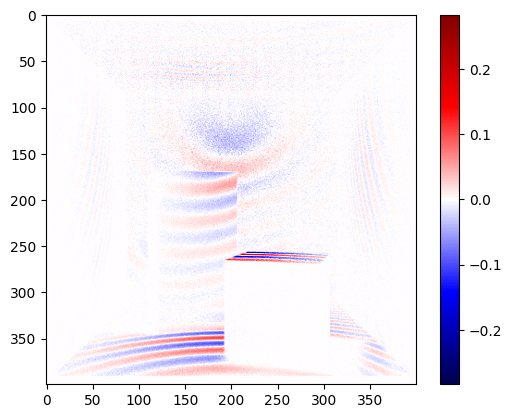

In [7]:
import matplotlib.pyplot as plt
import numpy as np
data_transient = np.array(data_transient)
max_val = max(np.max(data_transient), -np.min(data_transient))
for i in range(data_transient.shape[-1] // 2):
    img = np.zeros(data_transient.shape[:2], dtype=np.complex64)
    img = data_transient[..., i*2+0] + data_transient[..., i*2+1] * 1j
    plt.imshow(np.real(img), cmap='seismic', vmin=-max_val, vmax=max_val)
    plt.colorbar()
    plt.show()